In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import cv2

2.0.0-beta1


In [2]:
IMG_HEIGH = 218
IMG_WIDTH = 178
IMG_DETH= 3
MAX_SIZE=64
CLASS_LIMIT=32

In [3]:
def resize_with_aspect_ratio(image, MAX_SIZE):

    H, W = image.shape[0:2]
    
    # Take the greater value, and use it for the ratio
    max_ = np.min([H, W])
    ratio = max_ / MAX_SIZE

    W_ = W / ratio
    H_ = H / ratio

    W_, H_ = W_.astype(np.int32), H_.astype(np.int32)
    image = cv2.resize(image, (W_,H_), interpolation=cv2.INTER_AREA)
    
    H, W = image.shape[0:2]
    
    if H > MAX_SIZE:
        margin = H - MAX_SIZE
        start_y = margin // 2
        image = image[start_y:start_y+MAX_SIZE, 0:W]
    elif W > MAX_SIZE:
        margin = W - MAX_SIZE
        start_y = margin // 2
        image =  image[:H, start_y: start_y+MAX_SIZE]
    return image

In [4]:
def read_records(features):
    image = features["image"]
    image = tf.reshape(image, (IMG_HEIGH, IMG_WIDTH, IMG_DETH))
    
    attributes = features['attributes']
    Male = attributes["Male"]
    Young = attributes["Young"]
    Smiling = attributes["Smiling"]
    return image, [Male, Young, Smiling]

In [5]:
# Construct a tf.data.Dataset
dataset = tfds.load(name="celeb_a", split=tfds.Split.TRAIN)
dataset = dataset.map(read_records)

# Build your input pipeline
dataset = dataset.shuffle(16000).batch(128).repeat(1).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [7]:
import os
import tensorflow as tf

TRAIN_DATASET_DIR="./tfrecords/"
if not os.path.exists(TRAIN_DATASET_DIR):
    os.mkdir(TRAIN_DATASET_DIR)
    
TRAIN_FILE = 'cface_train.tfrecords'
train_writer = tf.io.TFRecordWriter(os.path.join(TRAIN_DATASET_DIR,TRAIN_FILE))

In [8]:
class_distribution = {}
n_images = 0

for images, features in dataset:

    for img, f in zip(images,features.numpy()):

        class_id = 0
        if f[0] == True:
            class_id += 2**2
        if f[1] == True:
            class_id += 2**1
        if f[2] == True:
            class_id += 1
        
        if class_id in class_distribution and class_distribution[class_id] >= CLASS_LIMIT:
            continue
        
        img = resize_with_aspect_ratio(img.numpy(), MAX_SIZE) 
        
        if class_id not in class_distribution:
            class_distribution[class_id] = 1
        else:
            class_distribution[class_id] += 1
            
        image_h = img.shape[0]
        image_w = img.shape[1]
        img_raw = img.astype(np.float32).tostring()

        example = tf.train.Example(features=tf.train.Features(feature={
                                    'height': _int64_feature(image_h),
                                    'width': _int64_feature(image_w),
                                    'image_raw': _bytes_feature(img_raw),
                                    'target': _int64_feature(class_id)}))

        train_writer.write(example.SerializeToString())
        n_images+=1
        
print("Done writing {} images.".format(n_images))
train_writer.close()

Done writing 256 images.


## Testing dataset

In [9]:
def tf_record_parser(record):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'target': tf.io.FixedLenFeature((), tf.int64)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    image = tf.io.decode_raw(features['image_raw'], tf.float32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['target'], tf.int32)

    # reshape input and annotation images
    image = tf.reshape(image, (height, width, 3), name="image_reshape")

    return image, tf.cast(label, tf.int32)

In [10]:
class_distribution

{7: 32, 2: 32, 1: 32, 4: 32, 3: 32, 6: 32, 5: 32, 0: 32}

In [11]:
train_dataset = tf.data.TFRecordDataset("./tfrecords/cface_train.tfrecords")
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.repeat(8)
train_dataset = train_dataset.batch(256)

0.0 255.0


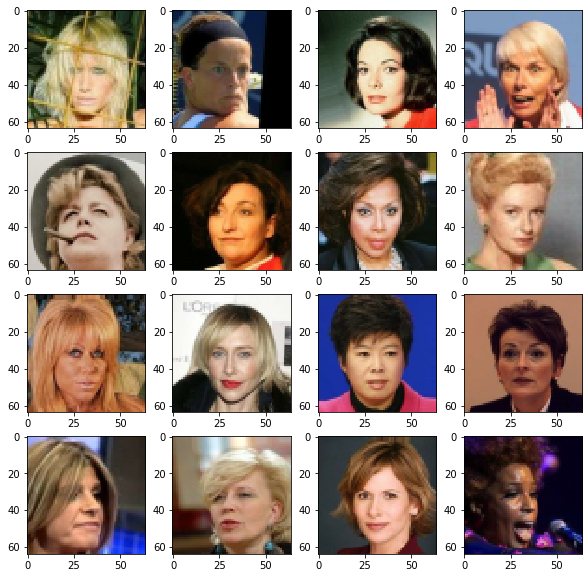

------------
0.0 255.0


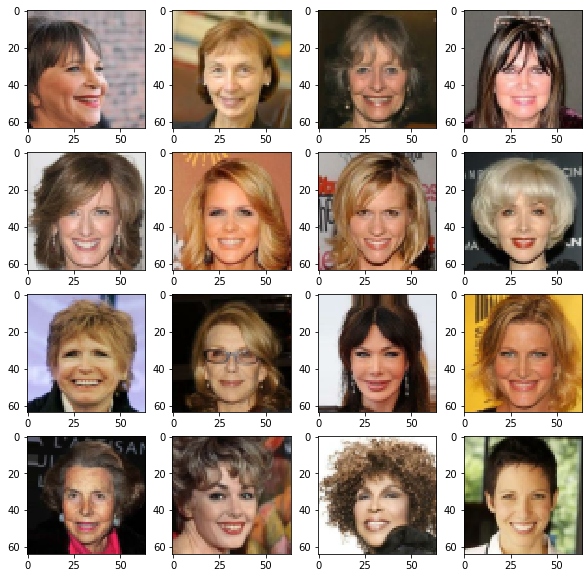

------------
0.0 255.0


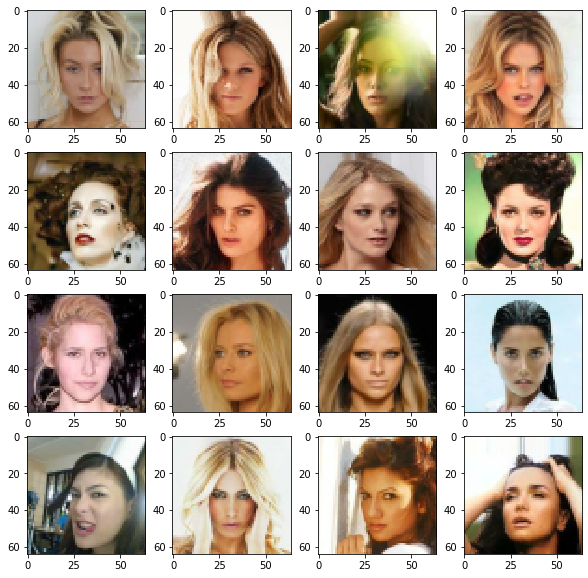

------------
0.0 255.0


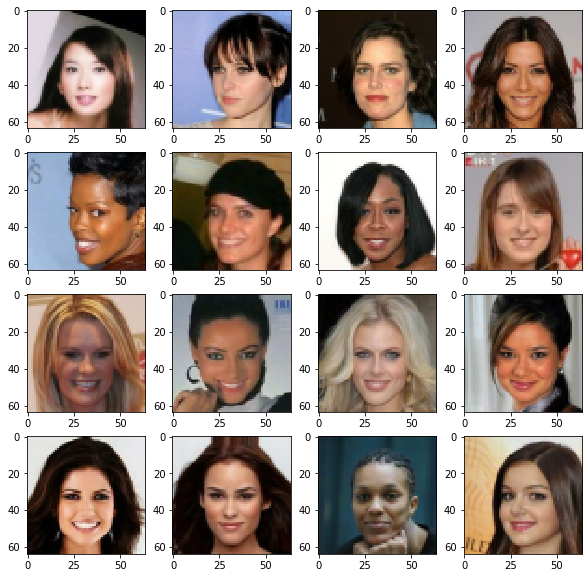

------------
0.0 255.0


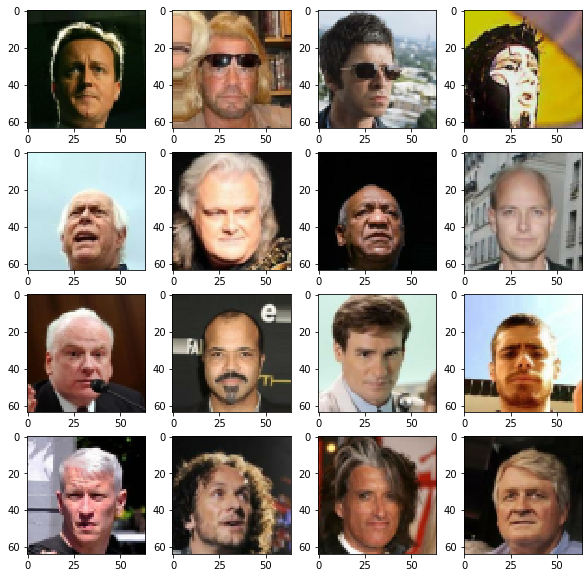

------------
0.0 255.0


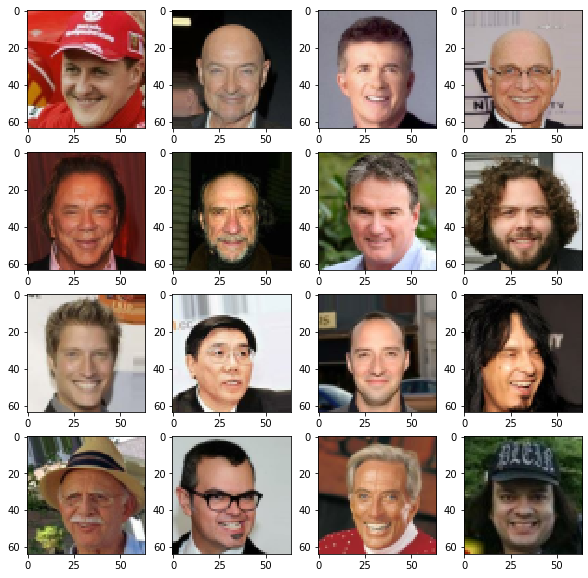

------------
0.0 255.0


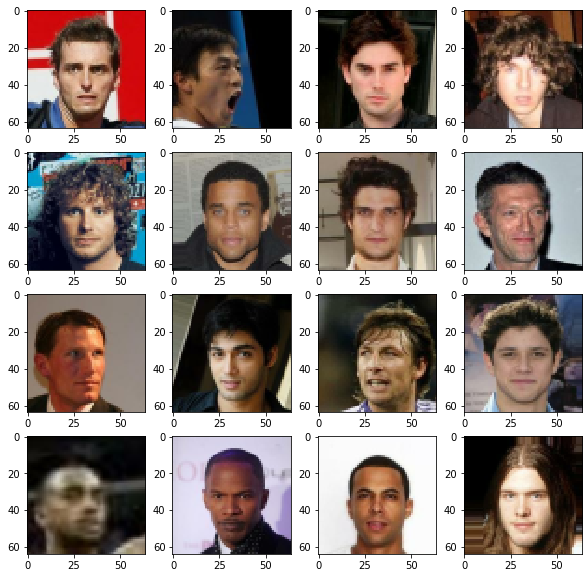

------------
0.0 255.0


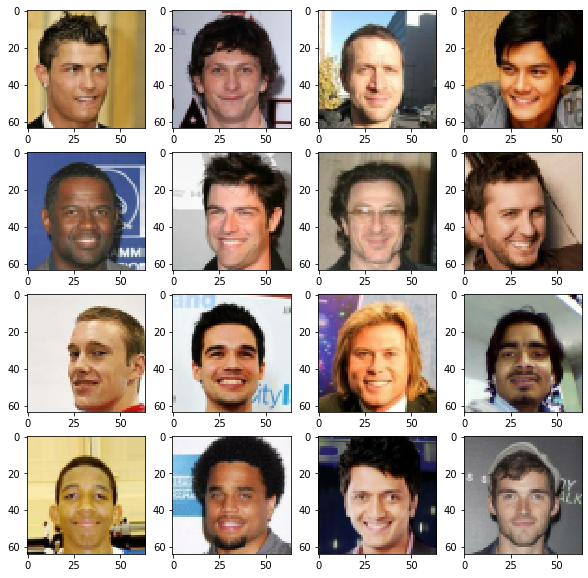

------------


In [13]:
for id_, (batch_images, batch_labels) in enumerate(train_dataset):
    print(np.min(batch_images), np.max(batch_images))
    fig, axs = plt.subplots(nrows=4, ncols=4, constrained_layout=False, figsize=(10,10))
    indices = np.where(batch_labels.numpy() == id_)[0]

    for i, ax in zip(indices, axs.flat):
       
        ax.imshow(batch_images[i] / 255)

    plt.show()
    print('------------')